In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 17.2MB/s 
     |████████████████████████████████| 1.2MB 55.2MB/s 
     |████████████████████████████████| 3.0MB 52.6MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0bdbbdd799a46f6756e795c863eea3577d951f5b656f530013252cca5a62a0c8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas
import numpy as np
import csv
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict, Counter
import time
from transformers import AutoModel
from torch import nn
import sys
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

In [4]:
filePath = "/content/drive/My Drive/MLNLP/FinalAssignment/train_reg.csv"
filePathTest = "/content/drive/My Drive/MLNLP/FinalAssignment/test_reg.csv"
filePathResult = "/content/drive/My Drive/MLNLP/FinalAssignment/"

In [5]:
def readData(fileName):
    # colnames = ['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']
    train_data = pandas.read_csv(fileName)
    X = train_data.text.tolist()
    Y = train_data.humor_rating.tolist()
    return X, Y

def readDataTest(fileName):
    test_data = pandas.read_csv(fileName)
    xTest = test_data.text.tolist()
    return xTest  
  
def writeData(fileName, testData, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    headings = ['text', 'humor_rating']
    writer = csv.writer(fileHandler)
    writer.writerows(zip(testData, resultList))
    # for iResult in resultList:
    #   fileHandler.write("%s\n" % iResult)

def evaluateTest(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    f1score = tp / (tp + 0.5*(fp + fn))
    return accuracy, f1score

In [6]:
def bert_tokenize_and_encode(tokenizer, documents, max_len):
    cls = tokenizer.cls_token_id
    sep = tokenizer.sep_token_id
    tokenized_docs = [tokenizer.tokenize(doc)[:max_len - 2] for doc in documents]
    out = [tokenizer.encode(doc) for doc in tokenized_docs]
    return out

In [8]:
class DocumentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    def __init__(self, pad):
        self.pad = pad

    def __call__(self, XY):
        max_len = max(len(x) for x, _ in XY)
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len - len(x)) for x, _ in XY])
        Y = torch.as_tensor([y for _,y in XY])
        return Xpadded, Y

In [32]:
class TextClassifier:
    def __init__(self, params, tokenizer):
        self.params = params
        self.tokenizer = tokenizer

    def epoch(self, batches, optimizer=None):
        n_instances = 0
        total_loss = 0

        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            prediction = self.model(Xbatch)  # Check what is scores
            loss = self.loss(torch.transpose(prediction,0,1)[0], Ybatch)
            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return total_loss

    def preprocess(self, X, Y):
        print('Preprocessing all documents...')
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
        self.voc_size = self.tokenizer.vocab_size

        batcher = DocumentBatcher(self.tokenizer.pad_token_id)

        train_docs = bert_tokenize_and_encode(self.tokenizer, Xtrain, self.params.max_len)
        train_dataset = DocumentDataset(train_docs, Ytrain)

        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_docs = bert_tokenize_and_encode(self.tokenizer, Xval, self.params.max_len)
        val_dataset = DocumentDataset(val_docs, Yval)
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                     collate_fn=batcher)
        print('... done.')

    def set_model(self, model):
        self.model = model

    def train(self):
        par = self.params
        self.model.to(par.device)
        self.loss = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)
        self.history = defaultdict(list)
        
        epoch = 0
        self.flagEpoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            t0 = time.time()
            self.model.train()
            train_loss = self.epoch(self.train_loader, optimizer)
            self.model.eval()         
            with torch.no_grad():
                val_loss = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(t1-t0)
            
            if epoch % 1 == 0:
                print(f'Epoch {epoch}: train loss:{train_loss:.4f},'
                      + f'val loss: {val_loss:.4f}, time: {t1-t0:.4f}') 

            # flagEpochArray = np.zeros(5, dtype = int)
            # if epoch > 3:
            #   for iEpoch in range(1,3):
            #     if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
            #       flagEpochArray[iEpoch - 1] = 1
            # if np.sum(flagEpochArray) >= 2:
            #   self.flagEpoch = 1
            
            if epoch > 1:
              if self.history['val_loss'][epoch - 1] - self.history['val_loss'][epoch - 2] > 0:
                self.flagEpoch = 1

        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        dummy_labels = [np.random.randint(0,5,1) for x in X]        

        enc_docs = bert_tokenize_and_encode(self.tokenizer, X, self.params.max_len)
        dataset = DocumentDataset(enc_docs, 
                                  dummy_labels)
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)
        self.model.eval()
        output = []
        with torch.no_grad():
            for Xbatch, Ybatch in loader:
                Xbatch = Xbatch.to(self.params.device)
                Ybatch = Ybatch.to(self.params.device)
                predictions = self.model(Xbatch)
                predictions = torch.transpose(predictions,0,1)[0]
                output.extend(predictions.cpu().numpy())
        return output

In [33]:
class BERTEncoder(nn.Module):

    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.output_size = self.bert.config.hidden_size

    def forward(self, documents):
        bert_outputs = self.bert(documents)
        top_layer_output = bert_outputs[0]
        cls_output = top_layer_output[:, 0, :]
        print('.', end='')
        sys.stdout.flush()
        return cls_output

In [34]:
class TextClassifierParametersBERT:
    device = 'cuda'
    n_epochs = 15
    batch_size = 32
    eta = 5e-5
    decay = 0
    dropout = 0.2
    max_len = 128

def main():
    global clf
    
    torch.manual_seed(0)

    X, Y = readData(filePath)
    
    bert_model_name = 'distilbert-base-uncased'
    use_bert = True
    
    if use_bert:
        params = TextClassifierParametersBERT()
    
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    
    clf = TextClassifier(params, tokenizer)
    
    clf.preprocess(X, Y)
    
    if use_bert:
        encoder = BERTEncoder(bert_model_name)

    clf.set_model(nn.Sequential(
            encoder,
            nn.Dropout(params.dropout),
            nn.Linear(encoder.output_size, out_features=10),
            nn.Linear(10, out_features=1)
    ))

    clf.train()
    return clf

In [35]:
# With early stopping criteria
bertModel = main()

Preprocessing all documents...
... done.
.......................................................................................................................................Epoch 1: train loss:54.0727,val loss: 8.0073, time: 21.6030
.......................................................................................................................................Epoch 2: train loss:31.5168,val loss: 6.9537, time: 22.1916
.......................................................................................................................................Epoch 3: train loss:26.1594,val loss: 6.8885, time: 21.9356
.......................................................................................................................................Epoch 4: train loss:16.0367,val loss: 8.2803, time: 21.7611


In [15]:
def plotit_bert():
    plt.figure()
    plt.plot(bertModel.history['train_loss'], label = "TrainLoss")
    plt.plot(bertModel.history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Loss-Epoch Plot")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_reg_loss.eps"
    plt.savefig(figName)

    return clf

In [ ]:
plotit_bert()

....................Mean Squared Error : 0.3138509418837724
R^2 : 0.036958160203787616
Accuracy wothin 0.5 and -0.5 is  0.6444805194805194


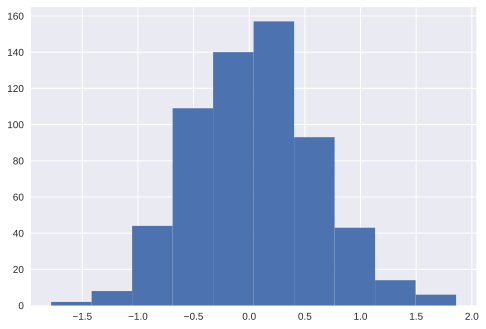

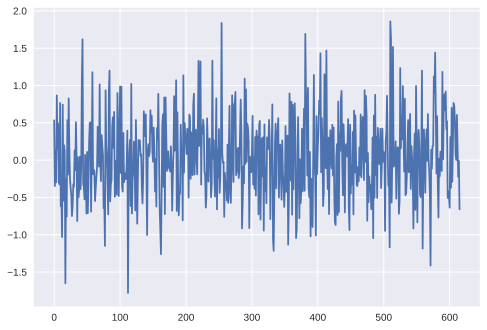

In [37]:
# BERT performances
X, Y = readData(filePathTest)
icase = 0
resultList = bertModel.predict(X)
fileNameRes = "BERT_reg_.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, X, resultList)

mse = mean_squared_error(Y, resultList)
r_square = r2_score(Y, resultList)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

countMe = 0
for i in range(len(resultList)):
  if -0.5 <= resultList[i] - Y[i] <= 0.5:
    countMe += 1
accMe = countMe/len(Y)
print("Accuracy wothin 0.5 and -0.5 is ", accMe)

difference = [resultList[i] - Y[i] for i in range(len(Y))]
plt.figure(icase)
plt.hist(difference)
histName = "/content/drive/My Drive/MLNLP/FinalAssignment/hist_BERT.eps"
plt.savefig(histName)

plt.figure()
plt.plot([resultList[i] - Y[i] for i in range(len(Y))])
figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_residual.eps"
plt.savefig(figName)

writeData(fileName, Y, resultList)

In [39]:
# No early stopping criteria
class TextClassifier:
    def __init__(self, params, tokenizer):
        self.params = params
        self.tokenizer = tokenizer

    def epoch(self, batches, optimizer=None):
        n_instances = 0
        total_loss = 0

        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            prediction = self.model(Xbatch)  # Check what is scores
            loss = self.loss(torch.transpose(prediction,0,1)[0], Ybatch)
            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return total_loss

    def preprocess(self, X, Y):
        print('Preprocessing all documents...')
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
        self.voc_size = self.tokenizer.vocab_size

        batcher = DocumentBatcher(self.tokenizer.pad_token_id)

        train_docs = bert_tokenize_and_encode(self.tokenizer, Xtrain, self.params.max_len)
        train_dataset = DocumentDataset(train_docs, Ytrain)

        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_docs = bert_tokenize_and_encode(self.tokenizer, Xval, self.params.max_len)
        val_dataset = DocumentDataset(val_docs, Yval)
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                     collate_fn=batcher)
        print('... done.')

    def set_model(self, model):
        self.model = model

    def train(self):
        par = self.params
        self.model.to(par.device)
        self.loss = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)
        self.history = defaultdict(list)
        
        epoch = 0
        self.flagEpoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            t0 = time.time()
            self.model.train()
            train_loss = self.epoch(self.train_loader, optimizer)
            self.model.eval()         
            with torch.no_grad():
                val_loss = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(t1-t0)
            
            if epoch % 1 == 0:
                print(f'Epoch {epoch}: train loss:{train_loss:.4f},'
                      + f'val loss: {val_loss:.4f}, time: {t1-t0:.4f}') 

            # flagEpochArray = np.zeros(5, dtype = int)
            # if epoch > 3:
            #   for iEpoch in range(1,3):
            #     if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
            #       flagEpochArray[iEpoch - 1] = 1
            # if np.sum(flagEpochArray) >= 2:
            #   self.flagEpoch = 1
            
            # if epoch > 1:
            #   if self.history['val_loss'][epoch - 1] - self.history['val_loss'][epoch - 2] > 0:
            #     self.flagEpoch = 1

        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        dummy_labels = [np.random.randint(0,5,1) for x in X]        

        enc_docs = bert_tokenize_and_encode(self.tokenizer, X, self.params.max_len)
        dataset = DocumentDataset(enc_docs, 
                                  dummy_labels)
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)
        self.model.eval()
        output = []
        with torch.no_grad():
            for Xbatch, Ybatch in loader:
                Xbatch = Xbatch.to(self.params.device)
                Ybatch = Ybatch.to(self.params.device)
                predictions = self.model(Xbatch)
                predictions = torch.transpose(predictions,0,1)[0]
                output.extend(predictions.cpu().numpy())
        return output

In [40]:
class TextClassifierParametersBERT:
    device = 'cuda'
    n_epochs = 10
    batch_size = 32
    eta = 5e-5
    decay = 0
    dropout = 0.2
    max_len = 128

def main():
    global clf
    
    torch.manual_seed(0)

    X, Y = readData(filePath)
    
    bert_model_name = 'distilbert-base-uncased'
    use_bert = True
    
    if use_bert:
        params = TextClassifierParametersBERT()
    
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    
    clf = TextClassifier(params, tokenizer)
    
    clf.preprocess(X, Y)
    
    if use_bert:
        encoder = BERTEncoder(bert_model_name)

    clf.set_model(nn.Sequential(
            encoder,
            nn.Dropout(params.dropout),
            nn.Linear(encoder.output_size, out_features=10),
            nn.Linear(10, out_features=1)
    ))

    clf.train()
    return clf

In [41]:
bertModel2 = main()

Preprocessing all documents...
... done.
.......................................................................................................................................Epoch 1: train loss:54.0727,val loss: 8.0073, time: 20.9658
.......................................................................................................................................Epoch 2: train loss:31.5168,val loss: 6.9537, time: 21.4402
.......................................................................................................................................Epoch 3: train loss:26.1594,val loss: 6.8885, time: 22.0241
.......................................................................................................................................Epoch 4: train loss:16.0367,val loss: 8.2803, time: 22.2703
.......................................................................................................................................Epoch 5: train loss:8.9513,val loss: 7.6584,

In [43]:
def plotit_bert():
    plt.figure()
    plt.plot(bertModel2.history['train_loss'], label = "TrainLoss")
    plt.plot(bertModel2.history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Loss-Epoch Plot")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_reg_loss_no_stopping.eps"
    plt.savefig(figName)

    return clf

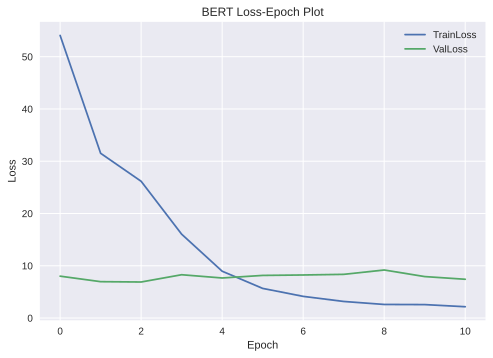

In [44]:
plotit_bert()

....................Mean Squared Error : 0.28067074883011356
R^2 : 0.13877054914038833
Accuracy wothin 0.5 and -0.5 is  0.6574675324675324


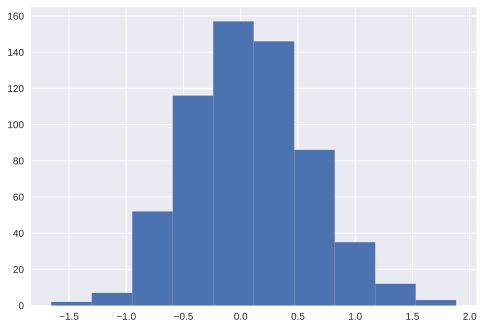

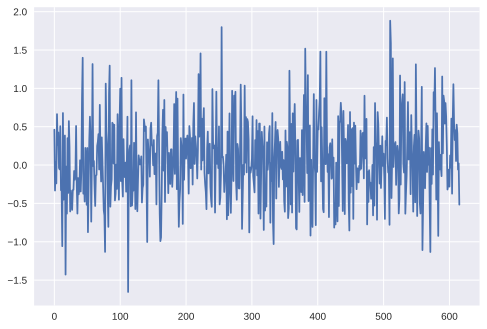

In [46]:
# BERT performances
X, Y = readData(filePathTest)
icase = 0
resultList = bertModel2.predict(X)
fileNameRes = "BERT_reg_No_stopping.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, X, resultList)

mse = mean_squared_error(Y, resultList)
r_square = r2_score(Y, resultList)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

countMe = 0
for i in range(len(resultList)):
  if -0.5 <= resultList[i] - Y[i] <= 0.5:
    countMe += 1
accMe = countMe/len(Y)
print("Accuracy wothin 0.5 and -0.5 is ", accMe)

difference = [resultList[i] - Y[i] for i in range(len(Y))]
plt.figure(icase)
plt.hist(difference)
histName = "/content/drive/My Drive/MLNLP/FinalAssignment/hist_BERT_no-stopping.eps"
plt.savefig(histName)

plt.figure()
plt.plot([resultList[i] - Y[i] for i in range(len(Y))])
figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_residual_no_stopping.eps"
plt.savefig(figName)

writeData(fileName, Y, resultList)